# Machine Learning for Nanofiltration (NF) Rejection Prediction

## Project Overview
This project develops machine learning models to predict the rejection of different ions during nanofiltration (NF).  
Key parameters such as feed composition, temperature, pressure, membrane MWCO, and pH are used to make predictions.

## Goal
- Train different ML models to predict rejection rates.
- Compare model performance using RMSE and R² metrics.
- Perform feature selection and hyperparameter tuning to optimize results.
- Check residuals to ensure there is no overfitting.
- Identify key influencing factors using ablation studies.

---


In [15]:
# Data handling and processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Machine Learning models
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.ensemble import StackingRegressor

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load the dataset (assuming it's already saved as CSV in same directory)
df = pd.read_csv(os.getcwd() + '\\NF_data.csv')  # Update with actual file location

# Display first few rows
df.head()

,Feed Ca,Feed Na,Feed K,Feed NH4,Feed Mg,Feed SO4,Feed PO4,Feed Cl,Temperature,Pressure,MWCO,pH,Ca,Na,K,NH4,Mg,SO4,PO4,Cl
0,49.963210,133.309818,33.553512,35.271635,29.027798,227.135984,6.834313,67.459755,35.209377,27.753028,400,6.731214,0.763845,0.659710,0.243480,0.088034,0.553308,0.050000,0.580980,0.724333
1,96.057145,293.855426,32.228092,40.850663,40.466184,263.046047,2.551477,134.047638,34.054905,17.659373,400,3.965292,0.725550,0.560249,0.050000,0.050564,0.576606,0.050000,0.526608,0.568569
2,78.559515,442.825626,91.562912,16.271055,38.247886,434.546327,8.851551,424.060612,13.351397,22.847667,300,7.138700,0.643492,0.050000,0.050000,0.050000,0.303590,0.491269,0.418118,0.638690
3,67.892679,379.501199,32.459158,33.119334,8.541095,203.001974,6.518046,395.045760,42.290034,15.337256,600,5.203499,0.624046,0.204657,0.411385,0.050000,0.435106,0.318281,0.303051,0.674127
4,32.481491,412.952517,34.475475,30.728569,8.313224,441.342358,2.414835,207.789211,29.896527,20.380899,500,3.366441,0.711767,0.219236,0.146621,0.100856,0.388306,0.050000,0.582944,0.685643


In [3]:
#add feature for sum of inital concentrations
df["Sum Feeds"] = df[["Feed Ca", "Feed Na", "Feed K", "Feed NH4", "Feed Mg", "Feed SO4", "Feed PO4", "Feed Cl"]].sum(axis=1)

## Initial Training ##

In [4]:
# Define features and target variables
features = ["Sum Feeds", "Temperature", "Pressure", "MWCO", "pH",]
targets = ["Ca", "Na", "K", "NH4", "Mg", "SO4", "PO4", "Cl"]

X = df[features]
Y = df[targets]

# Split data into train and test sets (80-20 split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=97)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Standardize target values (mainly for NN but will use for all)
Y_train_scaled = scaler.fit_transform(Y_train)
Y_test_scaled = scaler.transform(Y_test)


In [5]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=35),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=35),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(4,2), max_iter=1000, random_state=35)
}

# Train and evaluate models
results = []
for name, model in models.items():
    model.fit(X_train_scaled, Y_train_scaled)
    Y_pred = model.predict(X_test_scaled)
    
    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(Y_test_scaled, Y_pred))
    r2 = r2_score(Y_test_scaled, Y_pred)
    
    results.append({"Model": name, "RMSE": rmse, "R²": r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
results_df

,Model,RMSE,R²
0,Linear Regression,0.847016,0.328934
1,Random Forest,0.747624,0.484366
2,XGBoost,0.656101,0.610172
3,Neural Network,0.912619,0.221530


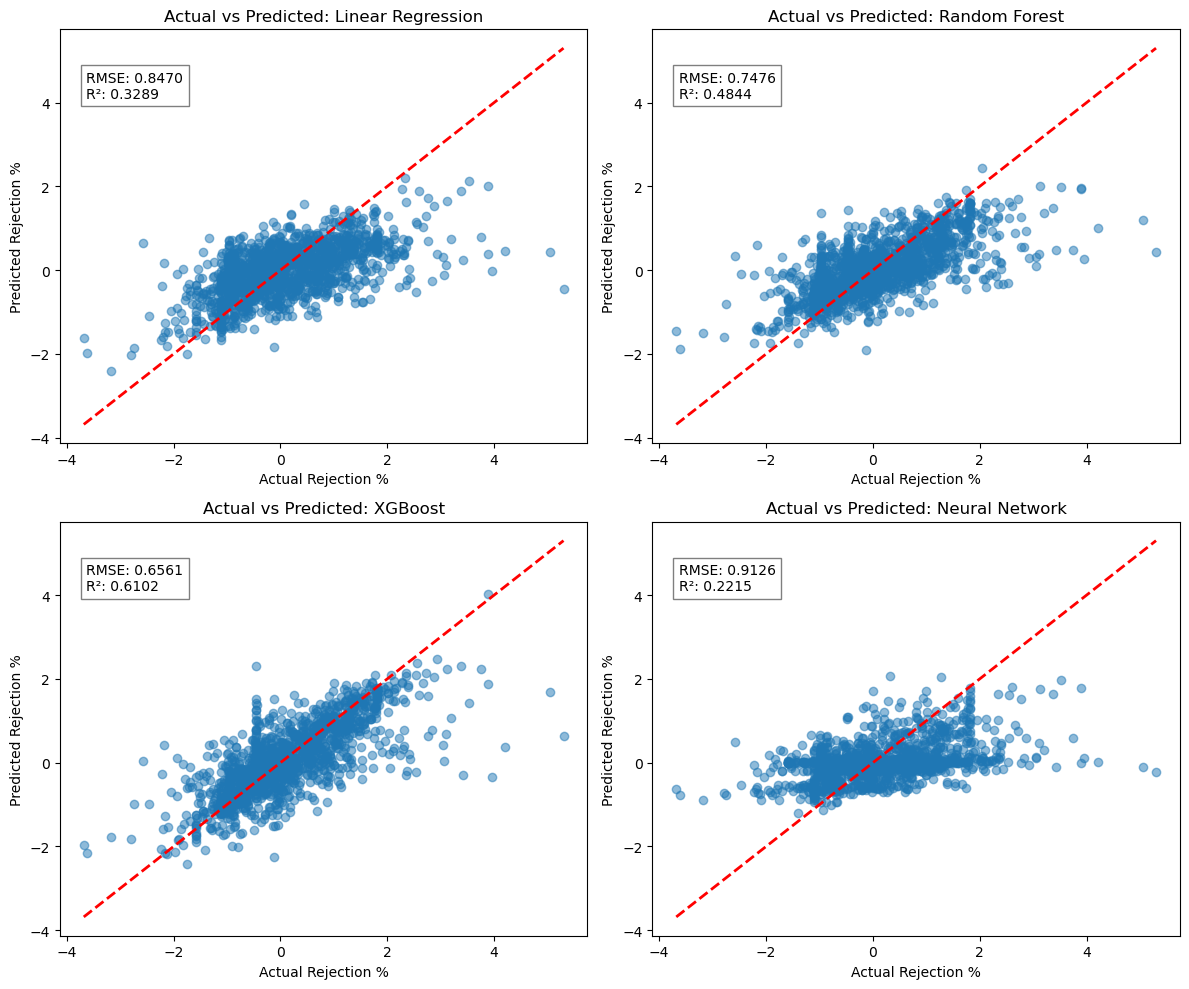

In [6]:
# Generate actual vs predicted plots for each model 
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    Y_pred = model.predict(X_test_scaled)

     # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(Y_test_scaled, Y_pred))
    r2 = r2_score(Y_test_scaled, Y_pred)

    # Plot actual vs predicted
    ax = axes[i]
    ax.scatter(Y_test_scaled.flatten(), Y_pred.flatten(), alpha=0.5)
    ax.plot([Y_test_scaled.min(), Y_test_scaled.max()], [Y_test_scaled.min(), Y_test_scaled.max()], 'r--', lw=2)
    ax.set_title(f"Actual vs Predicted: {name}")
    ax.set_xlabel("Actual Rejection %")
    ax.set_ylabel("Predicted Rejection %")

    # Add RMSE and R² as a text box in the plot
    textstr = f'RMSE: {rmse:.4f}\nR²: {r2:.4f}'
    ax.text(0.05, 0.90, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()


### Hyperparameter Tuning ###

In [7]:
# Suppress optuna warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

# -------------------- XGBoost Hyperparameter Tuning --------------------
def xgb_objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),  
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 100, 600), 
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),  # L1 Regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),  # L2 Regularization
    }
    
    model = XGBRegressor(**params, random_state=35, early_stopping_rounds=20)
    model.fit(X_train_scaled, Y_train_scaled, eval_set=[(X_test_scaled, Y_test_scaled)], verbose=False)
    Y_pred = model.predict(X_test_scaled)
    
    return mean_squared_error(Y_test_scaled, Y_pred)  # Optuna minimizes MSE

xgb_study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
xgb_study.optimize(xgb_objective, n_trials=50)  # Increased trials

best_params_xgb = xgb_study.best_params
print("Best XGBoost Hyperparameters:", best_params_xgb)

# -------------------- Random Forest Hyperparameter Tuning --------------------
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),  
        'max_depth': trial.suggest_int('max_depth', 5, 25),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ["sqrt", "log2", None]),
    }

    model = RandomForestRegressor(**params, random_state=35, n_jobs=-1)
    model.fit(X_train_scaled, Y_train_scaled)
    Y_pred = model.predict(X_test_scaled)
    
    return mean_squared_error(Y_test_scaled, Y_pred)

rf_study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
rf_study.optimize(rf_objective, n_trials=50)  # Increased trials

best_params_rf = rf_study.best_params
print("Best Random Forest Hyperparameters:", best_params_rf)

# -------------------- Neural Network Hyperparameter Tuning --------------------

def nn_objective(trial):
    hidden_layer_sizes_str = trial.suggest_categorical('hidden_layer_sizes', ['64-32', '16-8', '128-64-32'])
    hidden_layer_sizes = tuple(map(int, hidden_layer_sizes_str.split('-')))  # Convert string back to tuple

    params = {
        'hidden_layer_sizes': hidden_layer_sizes,
        'alpha': trial.suggest_float('alpha', 0.00001, 0.1, log = True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.0001, 0.01, log=True),
    }

    model = MLPRegressor(**params, max_iter=2000, random_state=35, early_stopping=True)
    model.fit(X_train_scaled, Y_train_scaled)
    Y_pred = model.predict(X_test_scaled)
    
    return mean_squared_error(Y_test_scaled, Y_pred)  # Minimize MSE

nn_study = optuna.create_study(direction="minimize")
nn_study.optimize(nn_objective, n_trials=50)  

best_params_nn = nn_study.best_params
best_params_nn["hidden_layer_sizes"] = tuple(map(int, best_params_nn["hidden_layer_sizes"].split('-')))
print("Best Neural Network Hyperparameters:", best_params_nn)



Best XGBoost Hyperparameters: {'learning_rate': 0.04756213308116011, 'max_depth': 4, 'n_estimators': 525, 'subsample': 0.8543199680572033, 'colsample_bytree': 0.9405292635194552, 'reg_alpha': 0.559193377546038, 'reg_lambda': 0.39953004849795354}
Best Random Forest Hyperparameters: {'n_estimators': 542, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}
Best Neural Network Hyperparameters: {'hidden_layer_sizes': (16, 8), 'alpha': 0.0006804940785955748, 'learning_rate_init': 0.0023465231031670774}


In [8]:
# Train Random Forest with best params
best_rf = RandomForestRegressor(**best_params_rf, random_state=35, n_jobs=-1)
best_rf.fit(X_train_scaled, Y_train_scaled)
Y_pred_rf = best_rf.predict(X_test_scaled)

rf_rmse = np.sqrt(mean_squared_error(Y_test_scaled, Y_pred_rf))
rf_r2 = r2_score(Y_test_scaled, Y_pred_rf)

# Train XGBoost with the best hyperparameters
best_xgb = XGBRegressor(**best_params_xgb, random_state=35)
best_xgb.fit(X_train_scaled, Y_train_scaled)
Y_pred_xgb = best_xgb.predict(X_test_scaled)

rmse_xgb = np.sqrt(mean_squared_error(Y_test_scaled, Y_pred_xgb))
r2_xgb = r2_score(Y_test_scaled, Y_pred_xgb)

# Train Neural Network with best params
best_params_nn["early_stopping"] = True
best_nn = MLPRegressor(**best_params_nn, max_iter=1000, random_state=35)
best_nn.fit(X_train_scaled, Y_train_scaled)
Y_pred_nn = best_nn.predict(X_test_scaled)

nn_rmse = np.sqrt(mean_squared_error(Y_test_scaled, Y_pred_nn))
nn_r2 = r2_score(Y_test_scaled, Y_pred_nn)

#Display results from models with tuned hyperparameters
optuna_results_df = pd.DataFrame({
    "Model": ["Random Forest (Optuna)", "XGBoost (Optuna)", "Neural Network (Optuna)"],
    "RMSE": [rf_rmse, rmse_xgb, nn_rmse],
    "R²": [rf_r2, r2_xgb, nn_r2]
})
optuna_results_df

,Model,RMSE,R²
0,Random Forest (Optuna),0.742678,0.490763
1,XGBoost (Optuna),0.633476,0.635760
2,Neural Network (Optuna),0.714749,0.528212


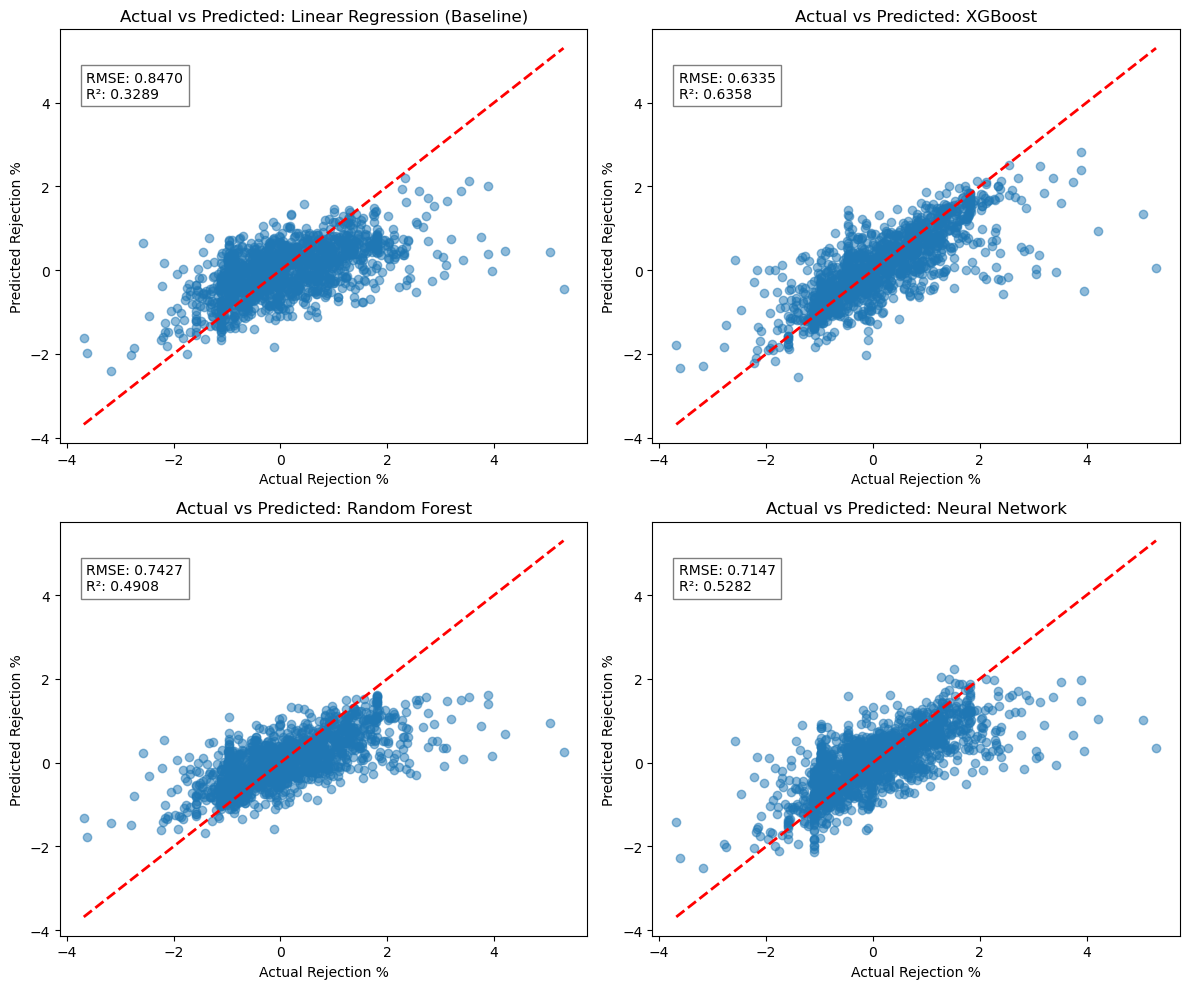

In [9]:
#PLot results of tuned models
best_models = {"Linear Regression (Baseline)": LinearRegression().fit(X_train_scaled, Y_train_scaled), "XGBoost":best_xgb, "Random Forest":best_rf, "Neural Network":best_nn}
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (name, model) in enumerate(best_models.items()):
    Y_pred = model.predict(X_test_scaled)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(Y_test_scaled, Y_pred))
    r2 = r2_score(Y_test_scaled, Y_pred)
    
    # Plot actual vs predicted
    ax = axes[i]
    ax.scatter(Y_test_scaled.flatten(), Y_pred.flatten(), alpha=0.5)
    ax.plot([Y_test_scaled.min(), Y_test_scaled.max()], [Y_test_scaled.min(), Y_test_scaled.max()], 'r--', lw=2)
    ax.set_title(f"Actual vs Predicted: {name}")
    ax.set_xlabel("Actual Rejection %")
    ax.set_ylabel("Predicted Rejection %")
    
    # Add RMSE and R² as a text box in the plot
    textstr = f'RMSE: {rmse:.4f}\nR²: {r2:.4f}'
    ax.text(0.05, 0.90, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

## Plot Residuals ##

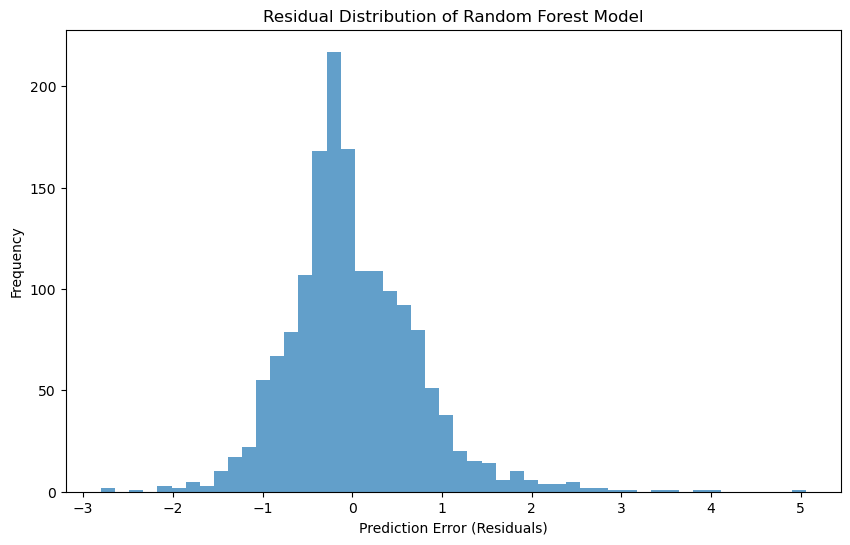

In [10]:
residuals = Y_test_scaled - Y_pred_rf
plt.figure(figsize=(10, 6))
plt.hist(residuals.flatten(), bins=50, alpha=0.7)
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("Residual Distribution of Random Forest Model")
plt.savefig("residualrfl.jpg", format='jpeg', dpi=300)
plt.show()

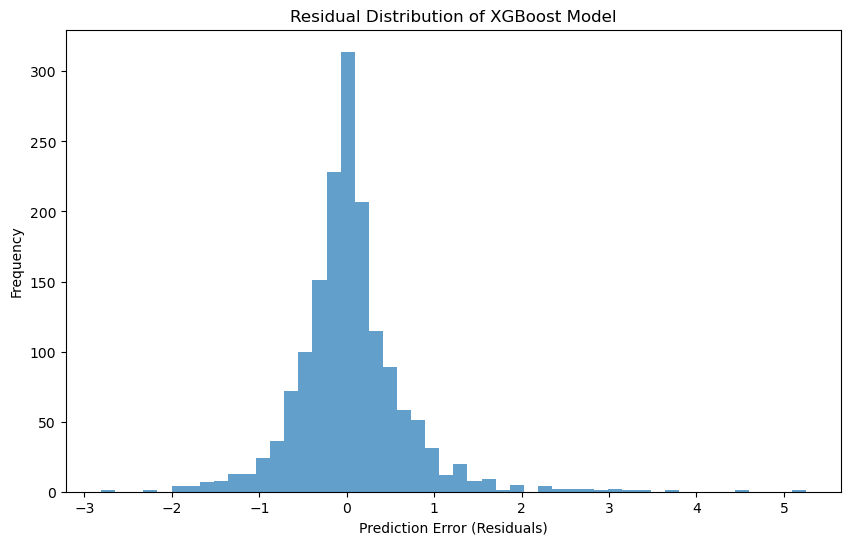

In [11]:
residuals = Y_test_scaled - Y_pred_xgb
plt.figure(figsize=(10, 6))
plt.hist(residuals.flatten(), bins=50, alpha=0.7)
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("Residual Distribution of XGBoost Model")
plt.savefig("residuaxgbl.jpg", format='jpeg', dpi=300)
plt.show()

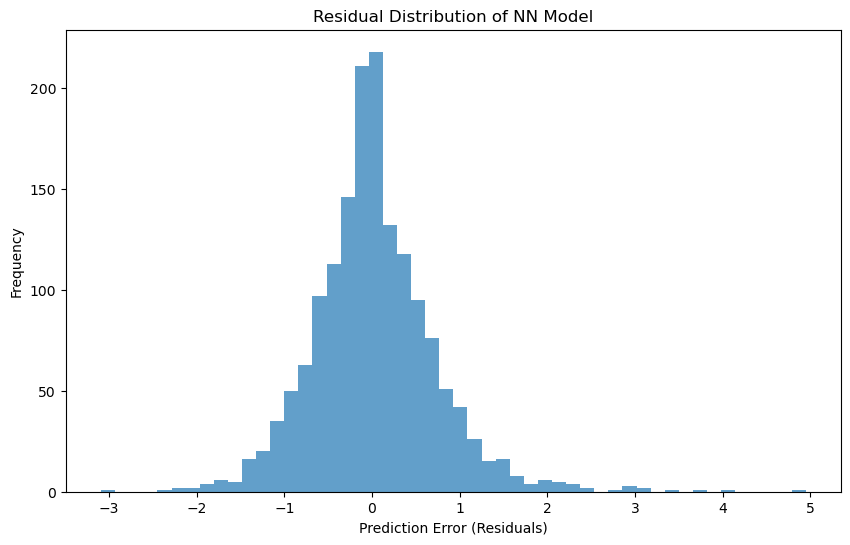

In [12]:
residuals = Y_test_scaled - Y_pred_nn
plt.figure(figsize=(10, 6))
plt.hist(residuals.flatten(), bins=50, alpha=0.7)
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("Residual Distribution of NN Model")
plt.savefig("residualnnl.jpg", format='jpeg', dpi=300)
plt.show()

## Try Ensemble Model ##

In [16]:
# Define base models (wrapped in MultiOutputRegressor)
base_models = [
    ('nn', best_nn),
    ('xgb', best_xgb)
]

# Define the meta-learner (XGB - best model)
stacking_model = MultiOutputRegressor(StackingRegressor(
    estimators=base_models,
    final_estimator=best_xgb
))


# Train the stacked model
stacking_model.fit(X_train_scaled, Y_train_scaled)

# Predict with the stacked model
Y_pred_stacking = stacking_model.predict(X_test_scaled)

# Evaluate performance
rmse_stacking = np.sqrt(mean_squared_error(Y_test_scaled, Y_pred_stacking))
r2_stacking = r2_score(Y_test_scaled, Y_pred_stacking)

print(f"Stacking Model - RMSE: {rmse_stacking:.4f}, R²: {r2_stacking:.4f}")

Stacking Model - RMSE: 0.6583, R²: 0.6070


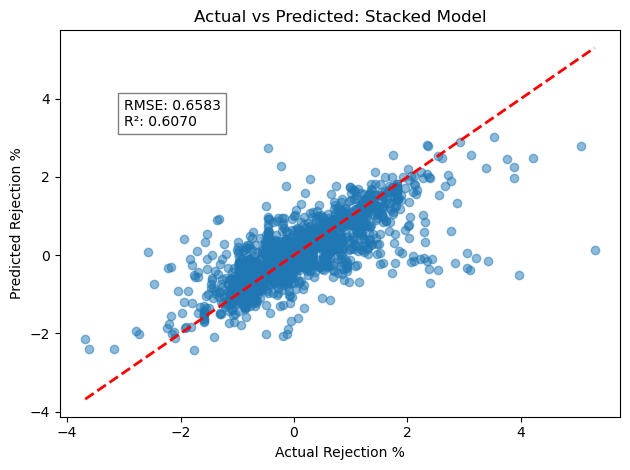

In [17]:
#plot performance
plt.scatter(Y_test_scaled.flatten(), Y_pred_stacking.flatten(), alpha=0.5)
plt.plot([Y_test_scaled.min(), Y_test_scaled.max()], [Y_test_scaled.min(), Y_test_scaled.max()], 'r--', lw=2)
plt.title(f"Actual vs Predicted: Stacked Model")
plt.xlabel("Actual Rejection %")
plt.ylabel("Predicted Rejection %")
# Add RMSE and R² as a text box in the plot
textstr = f'RMSE: {rmse_stacking:.4f}\nR²: {r2_stacking:.4f}'
plt.text(-3, 4, textstr, fontsize=10,
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.savefig("actual_vs_predicted_stack.jpg", format='jpeg', dpi=300)
plt.show()

## Feature Ablation Studies ##

In [18]:
def perform_ablation_study(model, X_train, X_test, Y_train, Y_test, feature_names):
    """Performs ablation by removing one feature at a time and evaluating model performance."""
    results = []

    # Train model with all features (Baseline)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    baseline_rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    baseline_r2 = r2_score(Y_test, Y_pred)
    results.append({"Feature Removed": "None (Baseline)", "RMSE": baseline_rmse, "R²": baseline_r2})

    # Iterate through each feature
    for feature in feature_names:
        X_train_reduced = np.delete(X_train, feature_names.index(feature), axis=1)
        X_test_reduced = np.delete(X_test, feature_names.index(feature), axis=1)

        # Train model without the selected feature
        model.fit(X_train_reduced, Y_train)
        Y_pred = model.predict(X_test_reduced)

        # Evaluate performance
        rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
        r2 = r2_score(Y_test, Y_pred)

        results.append({"Feature Removed": feature, "RMSE": rmse, "R²": r2})

    return pd.DataFrame(results)

In [19]:
# Perform ablation studies and show results
rf_ablation_results = perform_ablation_study(best_rf, X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, features)
xgb_ablation_results = perform_ablation_study(best_xgb, X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, features)
nn_ablation_results = perform_ablation_study(best_nn, X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, features)

In [20]:
#Linear Regression as baseline
lr_ablation_results = perform_ablation_study(LinearRegression(), X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, features)

In [21]:
lr_ablation_results

,Feature Removed,RMSE,R²
0,None (Baseline),0.847016,0.328934
1,Sum Feeds,0.947269,0.166391
2,Temperature,0.863646,0.301622
3,Pressure,0.880138,0.278667
4,MWCO,0.880736,0.274304
5,pH,0.870320,0.288710


In [22]:
rf_ablation_results

,Feature Removed,RMSE,R²
0,None (Baseline),0.742678,0.490763
1,Sum Feeds,0.831845,0.367493
2,Temperature,0.821493,0.371967
3,Pressure,0.780963,0.443156
4,MWCO,0.755425,0.474040
5,pH,0.834204,0.346861


In [23]:
xgb_ablation_results

,Feature Removed,RMSE,R²
0,None (Baseline),0.633476,0.635760
1,Sum Feeds,0.789752,0.436996
2,Temperature,0.846515,0.335416
3,Pressure,0.728905,0.522248
4,MWCO,0.692242,0.564578
5,pH,0.803962,0.395789


In [24]:
nn_ablation_results

,Feature Removed,RMSE,R²
0,None (Baseline),0.714749,0.528212
1,Sum Feeds,0.935272,0.185666
2,Temperature,0.819360,0.374979
3,Pressure,0.784537,0.439528
4,MWCO,0.842169,0.335630
5,pH,0.832576,0.350099


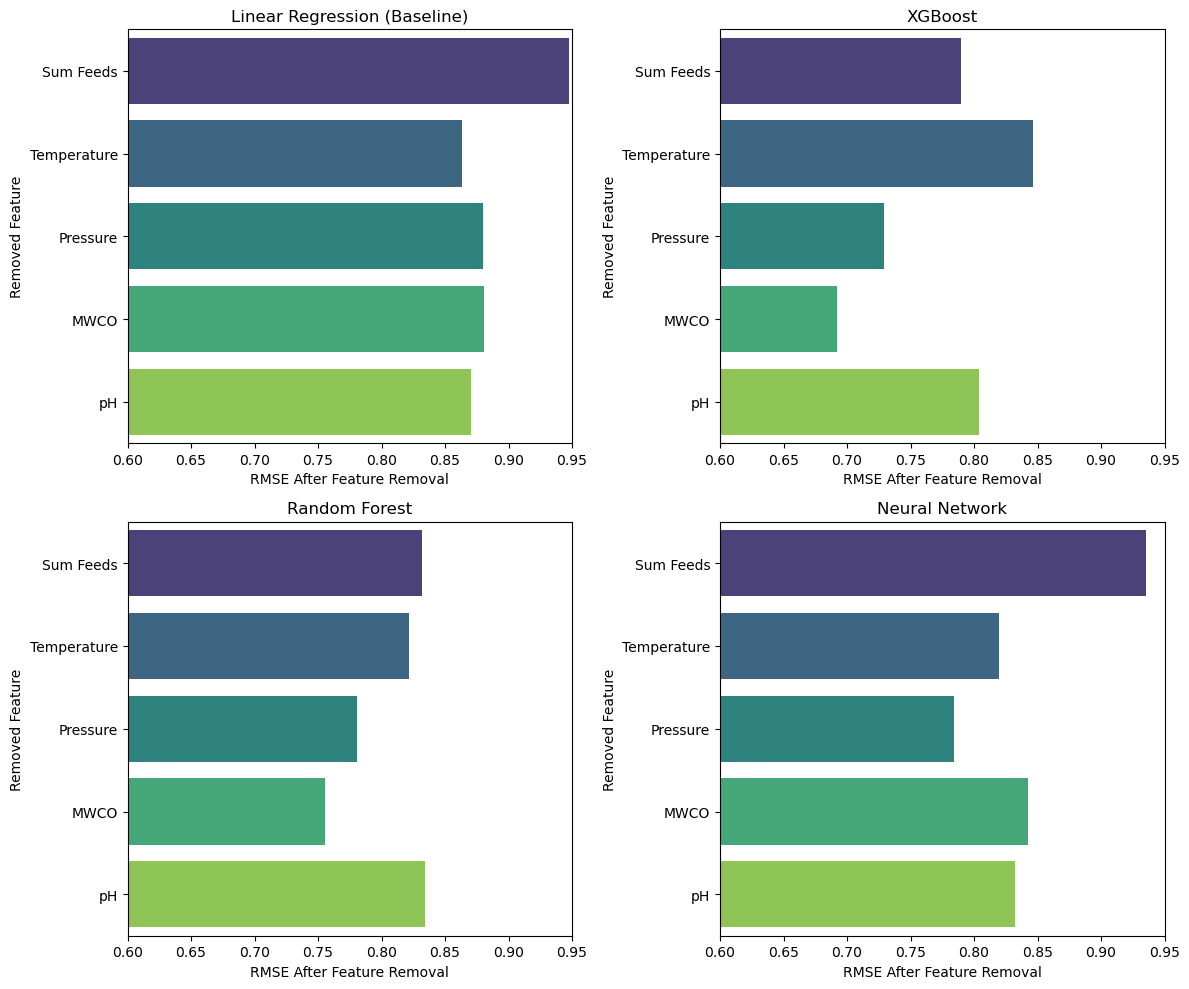

In [25]:
#plot bar chart of results to visually look at effect of each parameter
ablation_results = {"Linear Regression (Baseline)": lr_ablation_results, "XGBoost":xgb_ablation_results, "Random Forest":rf_ablation_results, "Neural Network":nn_ablation_results}
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (name, model) in enumerate(ablation_results.items()):
    # Plot RMSE impact when features are removed
    ax = axes[i] 
    sns.barplot(data=model.iloc[1:,:], x="RMSE", y="Feature Removed", palette="viridis", ax=ax)
    ax.set_xlabel("RMSE After Feature Removal")
    ax.set_ylabel("Removed Feature")
    ax.set_title(f"{name}")
    ax.set_xlim(.6,.95)
    
plt.tight_layout()
plt.show()



## Individual Ion fitting ##

In [26]:
def perform_target_study(name,model, X_train, X_test, Y_train, Y_test, target_names):
    """Performs ablation by removing one feature at a time and evaluating model performance."""
    results = []
    fig, axes = plt.subplots(4,2, figsize=(15, 15))
    axes = axes.flatten()
    i=0
    # Iterate through each target
    for target in target_names:
        Y_train_reduced = np.array(Y_train[target]).reshape(-1, 1) 
        Y_test_reduced = np.array(Y_test[target]).reshape(-1, 1) 

        Y_train_scaled = scaler.fit_transform(Y_train_reduced)
        Y_test_scaled = scaler.transform(Y_test_reduced)

        # Train model without the selected feature
        model.fit(X_train, Y_train_scaled)
        Y_pred = model.predict(X_test)

        # Evaluate performance
        rmse = np.sqrt(mean_squared_error(Y_test_scaled, Y_pred))
        r2 = r2_score(Y_test_scaled, Y_pred)

        results.append({"Target Ion": target, "RMSE": rmse, "R²": r2})
    
        # Plot actual vs predicted
        ax = axes[i]
        ax.scatter(Y_test_scaled.flatten(), Y_pred.flatten(), alpha=0.5)
        ax.plot([Y_test_scaled.min(), Y_test_scaled.max()], [Y_test_scaled.min(), Y_test_scaled.max()], 'r--', lw=2)
        ax.set_title(f"Actual vs Predicted: {target}")
        i += 1
    
    plt.tight_layout()
    plt.show()
      
    return pd.DataFrame(results)

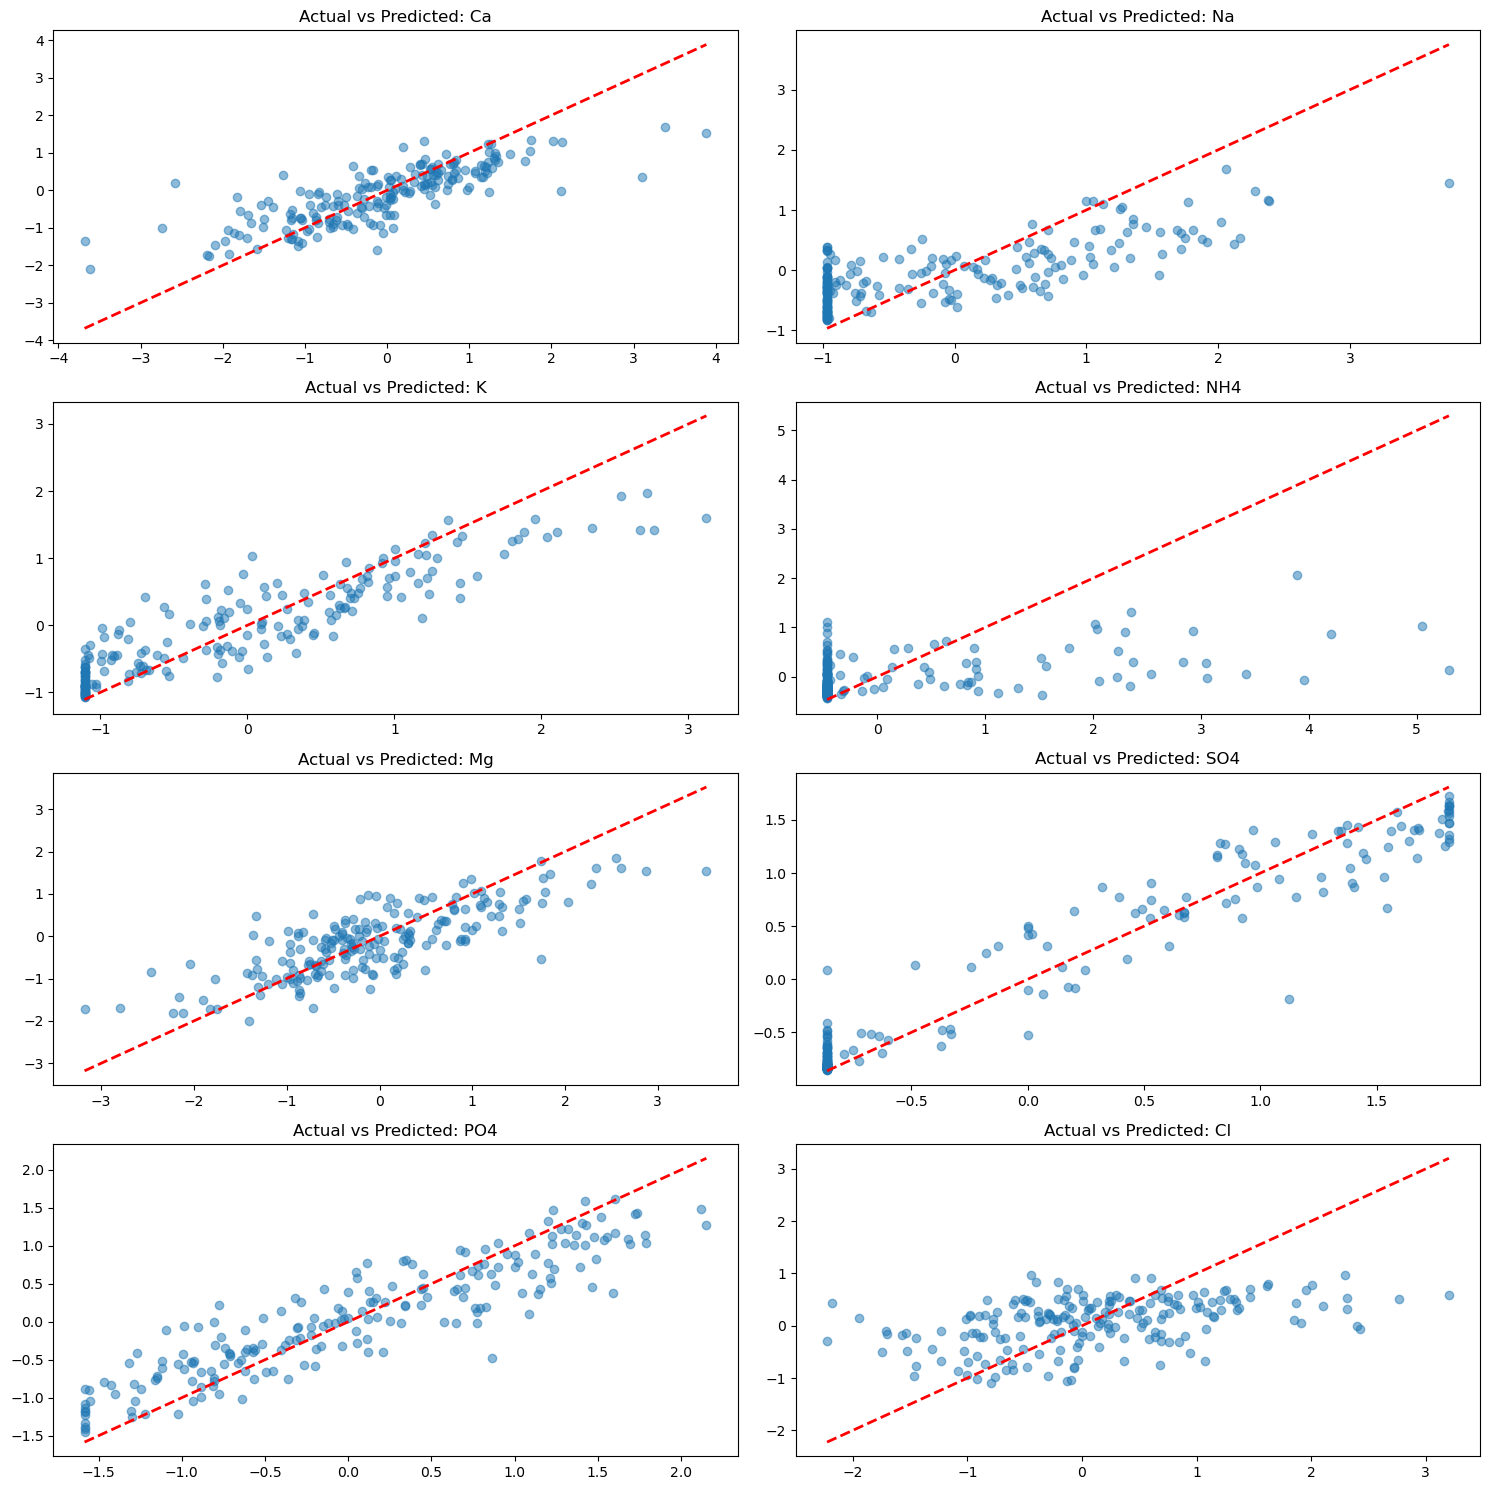

In [27]:
# Perform target studies -- see which ions the models are struggling to fit 
rf_target_results = perform_target_study('rf',best_rf, X_train_scaled, X_test_scaled, Y_train, Y_test, targets)

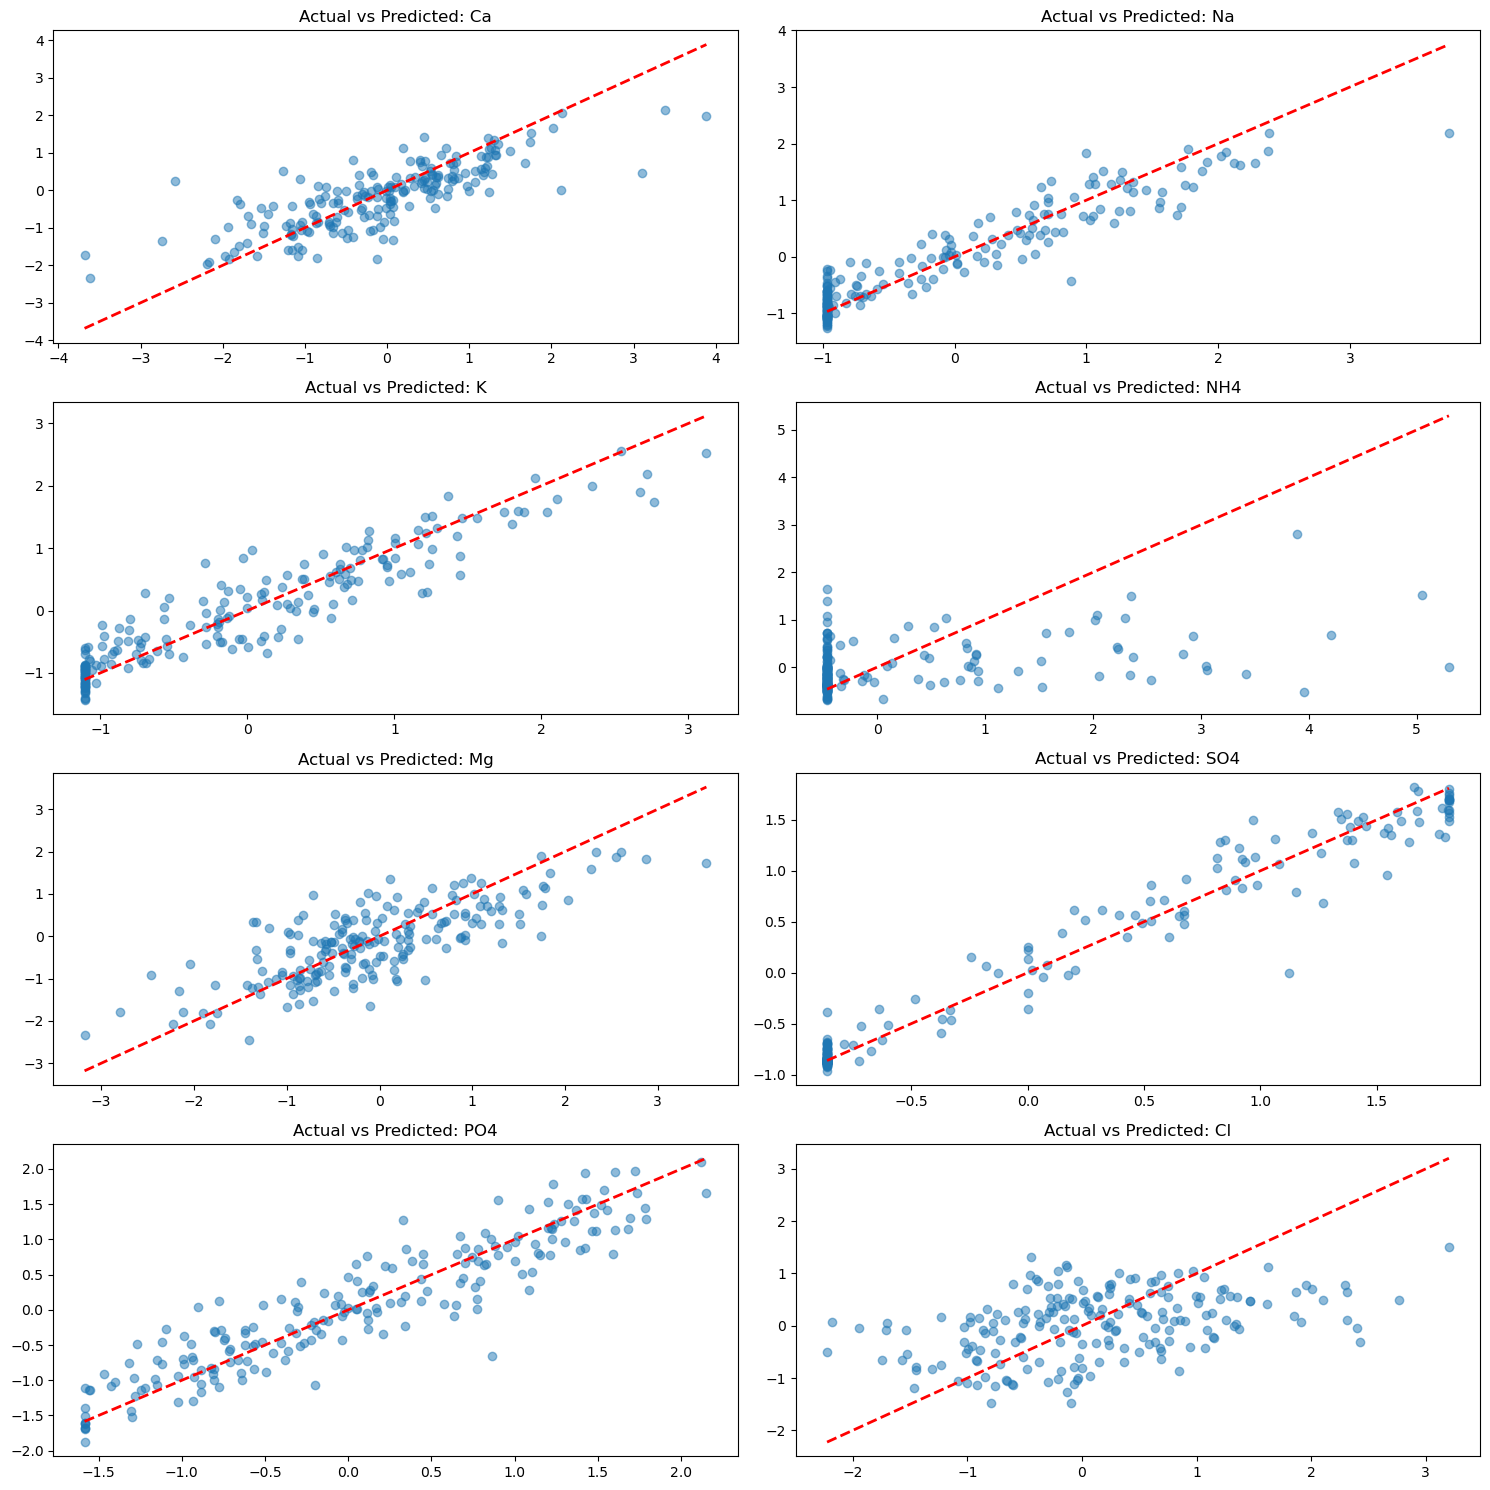

In [28]:
xgb_target_results = perform_target_study('xgb',best_xgb, X_train_scaled, X_test_scaled, Y_train, Y_test, targets)

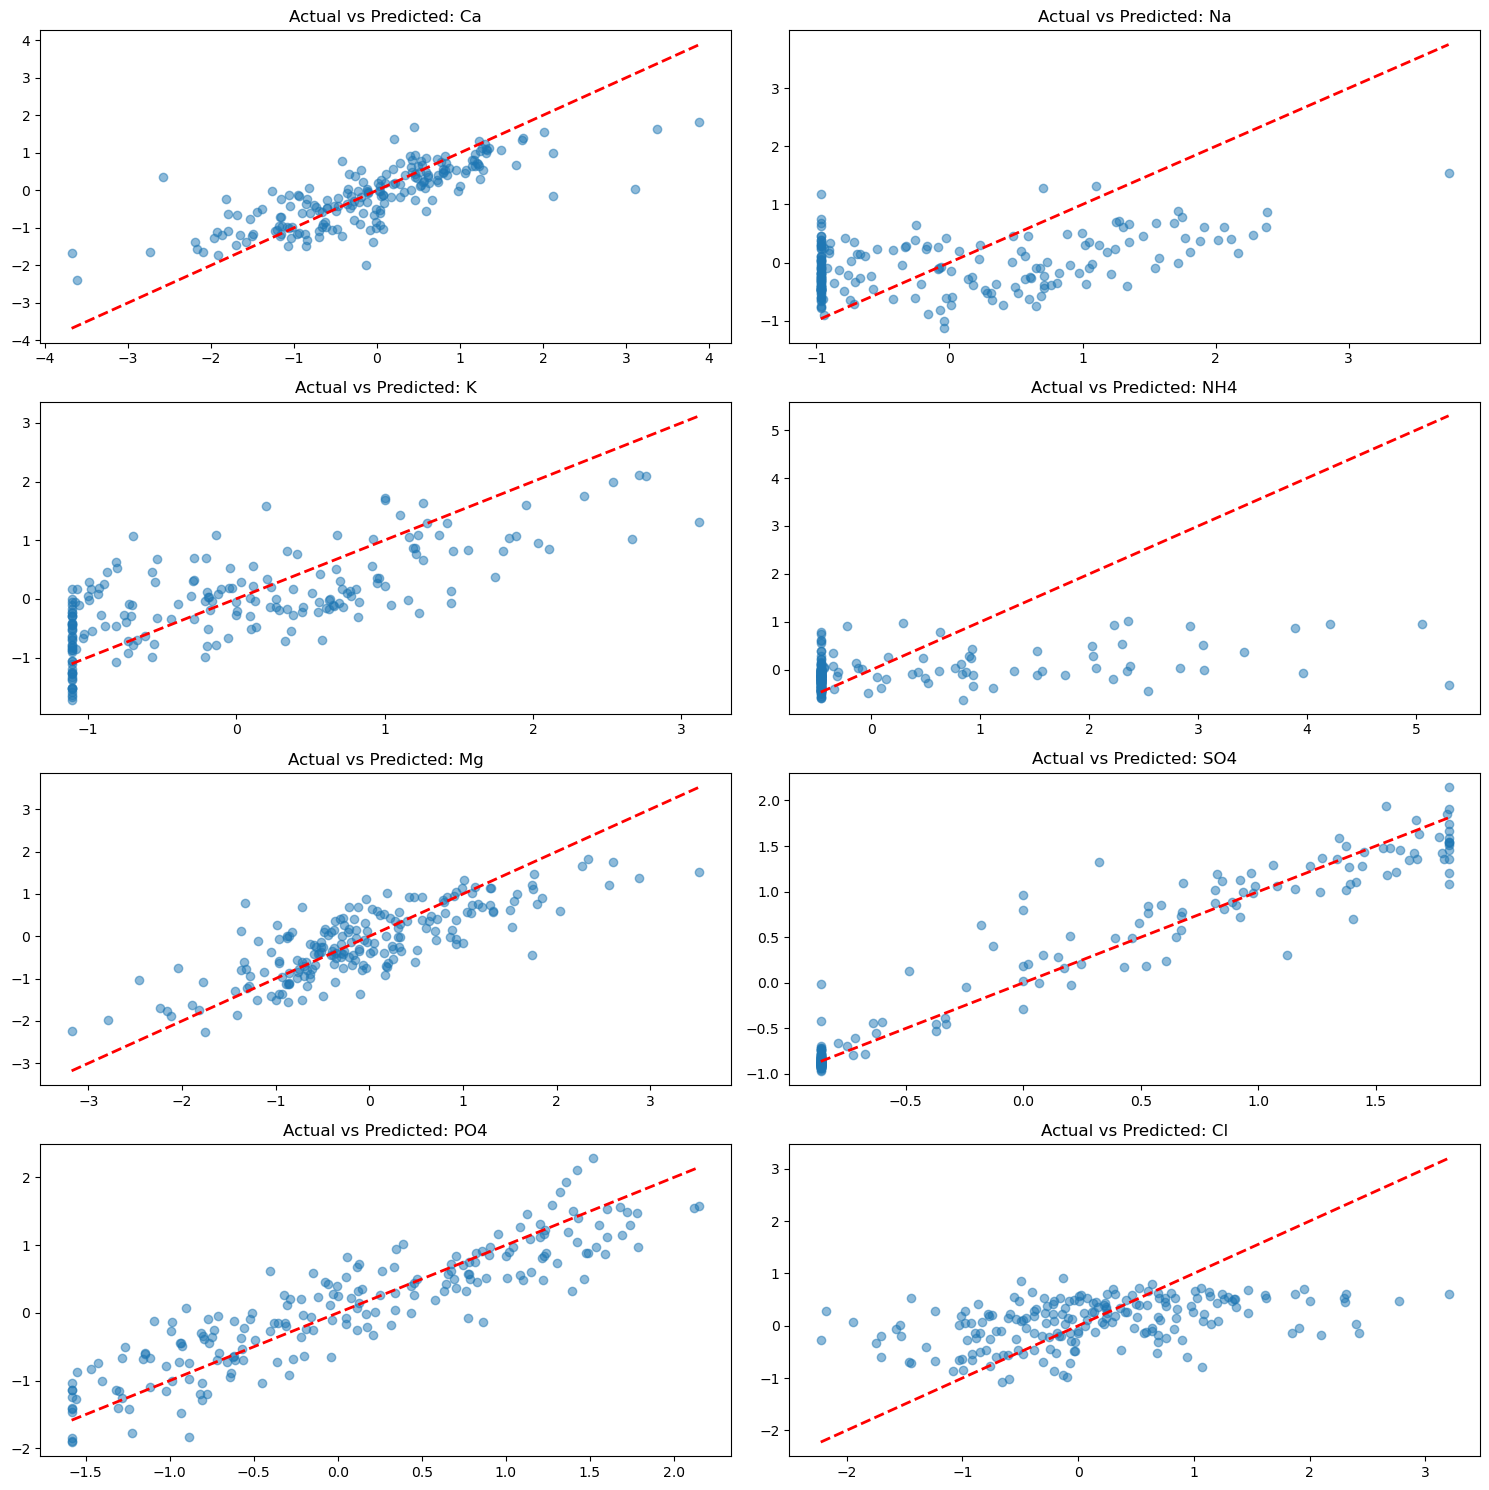

In [29]:
nn_target_results = perform_target_study('nn',best_nn, X_train_scaled, X_test_scaled, Y_train, Y_test, targets)

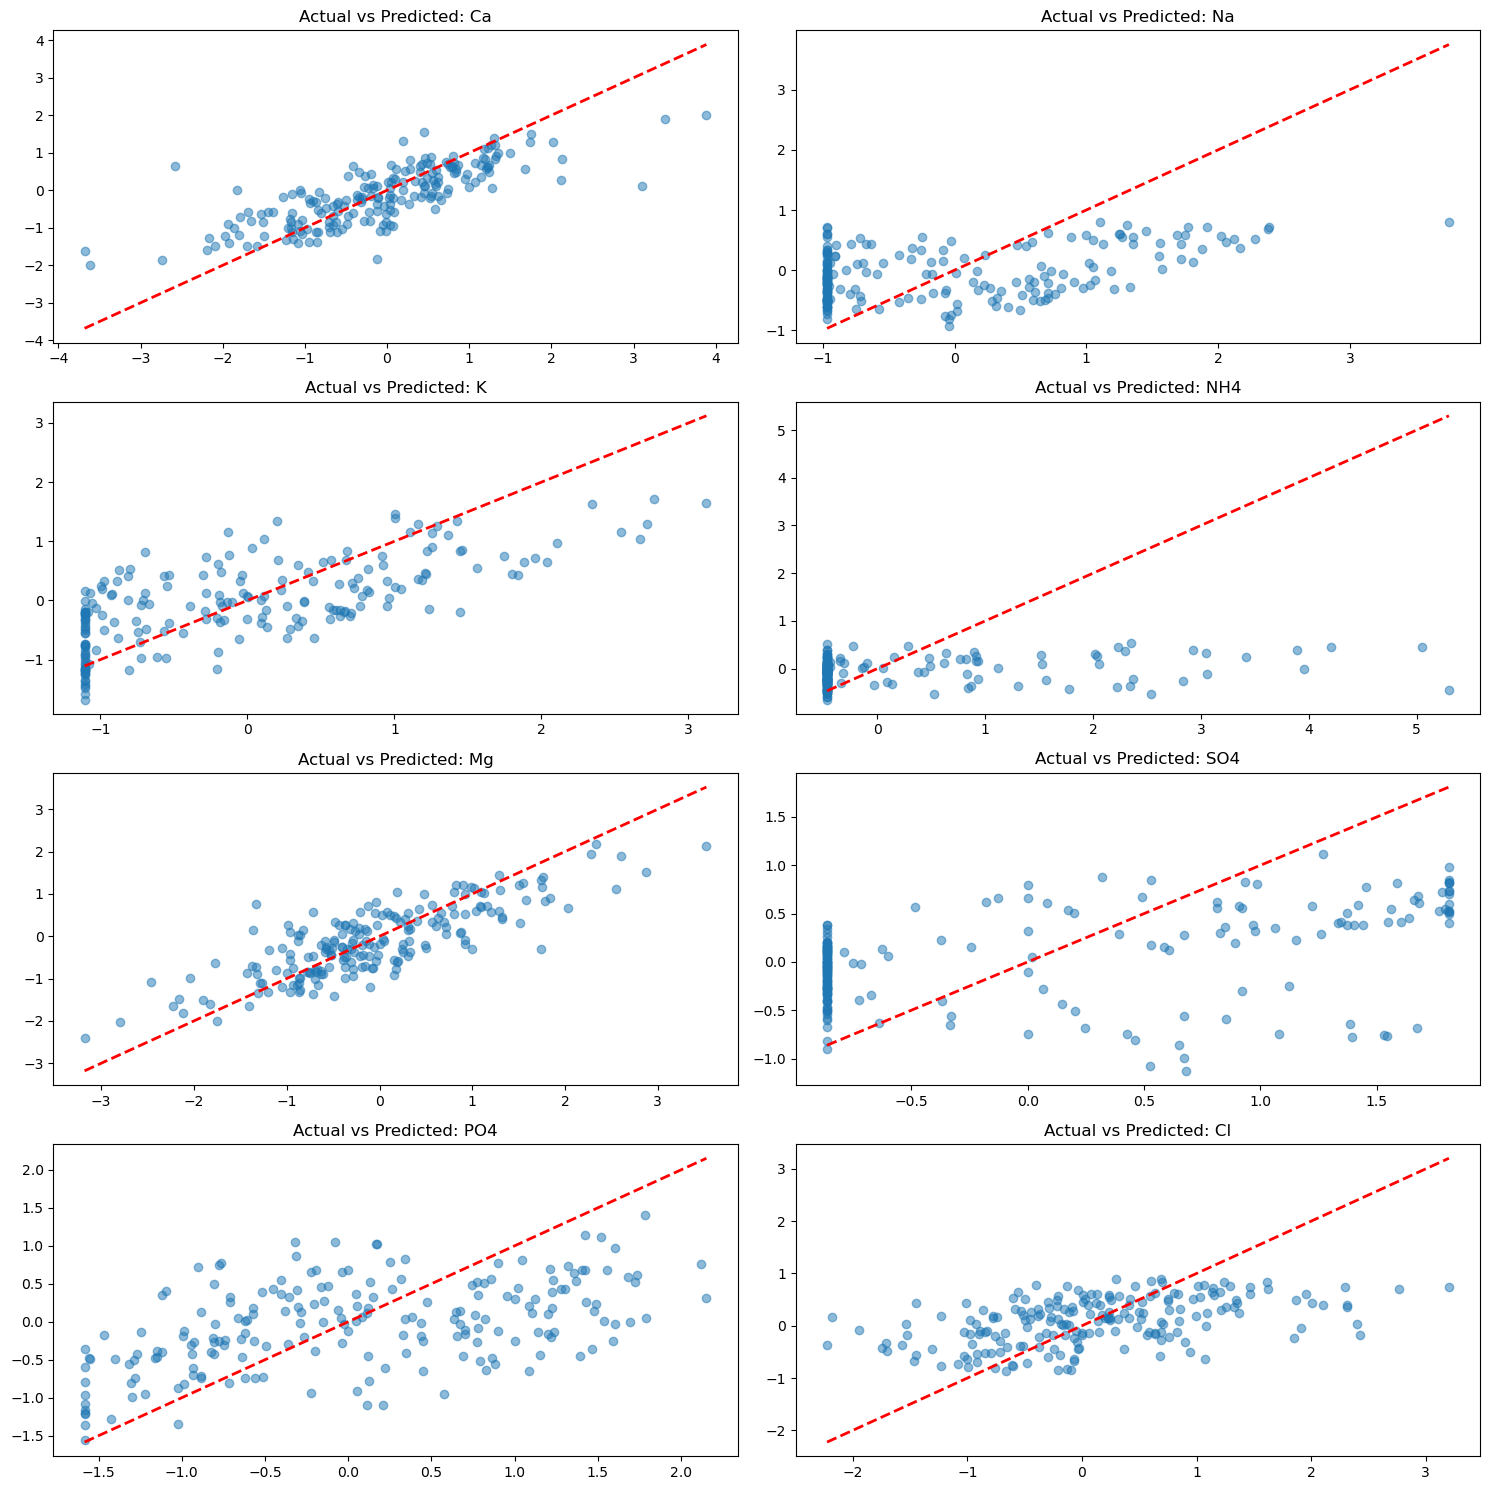

In [30]:
#Check linear regression as a baseline and display results below
lr_target_results = perform_target_study('lr',LinearRegression(), X_train_scaled, X_test_scaled, Y_train, Y_test, targets)

In [31]:
rf_target_results

,Target Ion,RMSE,R²
0,Ca,0.688865,0.619753
1,Na,0.708615,0.512125
2,K,0.456408,0.797147
3,NH4,0.997798,0.212511
4,Mg,0.651265,0.613608
5,SO4,0.265003,0.931741
6,PO4,0.429226,0.807808
7,Cl,0.872149,0.193451


In [32]:
xgb_target_results

,Target Ion,RMSE,R²
0,Ca,0.684106,0.624989
1,Na,0.343847,0.885127
2,K,0.358283,0.874995
3,NH4,1.031290,0.158758
4,Mg,0.679745,0.579073
5,SO4,0.186754,0.966100
6,PO4,0.369554,0.857531
7,Cl,0.917866,0.106679


In [33]:
nn_target_results

,Target Ion,RMSE,R²
0,Ca,0.684693,0.624345
1,Na,0.927405,0.164345
2,K,0.699577,0.523410
3,NH4,1.032776,0.156333
4,Mg,0.639552,0.627381
5,SO4,0.239748,0.944131
6,PO4,0.427938,0.808959
7,Cl,0.880164,0.178558


In [34]:
lr_target_results

,Target Ion,RMSE,R²
0,Ca,0.704192,0.602644
1,Na,0.921822,0.174376
2,K,0.719269,0.496202
3,NH4,1.101765,0.039855
4,Mg,0.612479,0.658260
5,SO4,0.909495,0.195993
6,PO4,0.855979,0.235651
7,Cl,0.852991,0.228495
